# Bibliotecas

In [54]:
from scipy.optimize import minimize
from tabulate import tabulate
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [55]:
%reset -f # clean Jupyter Variables

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clean, please run `%reset?` for details
Don't know how to reset  jupyter, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


# Parte I

In [56]:
def R(x, y, a=1, b=100):
    """
    Funcao de Rosenbrock R(x, y).

    Parametros:
        - x: (float ou lista de float). Variavel independente x.
        - y: (float ou lista de float). Variavel independente y.
        - a: (float). Constante a.
        - b: (float). Constante b.
    Retorno:
        - (float ou lista de float). Valor da funcao R(x, y).
    """

    return (a - x)**2 + b*(y - x**2)**2

def grad_R(x, y, a=1, b=100):
    """
    Gradiente da funcao de Rosenbrock R(x, y).

    Parametros:
        - x: (float ou lista de float). Variavel independente x.
        - y: (float ou lista de float). Vatiavel independente y.
        - a: (float). Constante a.
        - b: (float). Constante b.
    Retorno:
        - (float ou lista de float). Gradiente da funcao R(x, y).
    """

    dR_dx = -2*(a - x) - 4*b*x*(y - x**2)
    dR_dy = 2*b*(y - x**2)

    return np.array([dR_dx, dR_dy])

def hessiana_R(x, y, b=100):
    """
    Hessiana da funcao de Rosenbrock R(x, y).

    Parametros:
        - x: (float ou lista de float). Variavel independente x.
        - y: (float ou lista de float). Vatiavel independente y.
        - b: (float). Constante b.
    Retorno:
        - (float ou lista de float). Gradiente da funcao R(x, y).
    """

    h_11 = 2 - 4*b*y + 12*b*x**2
    h_12 = -4*b*x
    h_13 = -4*b*y
    h_14 = 2*b

    return np.array([[h_11, h_12], [h_13, h_14]])

## Exercício 1

### (b)

#### Caso I: regra de minimização unidimensional com $\hat{a} = 1$.

In [57]:
def metodo_secao_aurea(f, a, b=1.0, tol=1e-4, max_iter=100):
    """
    Metodo da Secao Aurea para minimizacao.

    Parametros:
        - f: (funcao). Funcao a ser minimizada.
        - a: (float). Limite inferior do intervalo (inclusive).
        - b: (float). Limite superior do intervalo (inclusive).
        - tol: (float). Tolerancia do valor do comprimento do intervalo como primeiro criterio de parada.
        - max_iter: (int). Numero maximo de iteracoes como segundo criterio de parada.
    Retorno:
        - (float). Comprimento do intervalo.
        - (int). Numero de avaliacoes da funcao.
    """

    rho = (np.sqrt(5) + 1)/2 # razao aurea
    l = b - a
    c = b - l/rho
    d = a + l/rho

    k = 0
    while abs(c - d) > tol and k < max_iter:
        # Atualizacao dos pontos para a proxima iteracao
        if f(c) < f(d): # minimo esta a esquerda
            b = d
        else: # minimo esta a direita
            a = c

        l = b - a
        c = b - l/rho
        d = a + l/rho

        k+=1

    return (a + b)/2, 2*k

def metodo_grad_busca_exata(p_0, f, grad_f, hessiana_f=None, alpha_max=1.0, tol=1e-4, max_iter=100):
    """
    Metodo do Gradiente com Busca Linear Exata.

    Parametros:
        - p_0: (float ou lista de float). Coordenadas do ponto inicial.
        - f: (funcao). Funcao f.
        - grad_f: (funcao). Gradiente de f.
        - hessiana_f: (funcao). Hessiana de f (metodo de Newton).
        - alpha_max: (float). Limite superior do Metodo da Secao Aurea.
        - tol: (float). Tolerancia para convergencia (norma do passo ou norma do gradiente de f) como primeiro criterio de parada.
        - max_iter: (int). Numero maximo de iteracoes como segundo criterio de parada.
    Retorno:
        - (lista de listas):
            Para cada iteracao:
            - k: (int). Iteracao.
            - [x_k, y_k]: (lista de float). Coordenadas x e y.
            - norma_passo_k: (float). Norma do passo.
            - norma_grad_f_k: (float). Norma do gradiente da funcao.
            - N_f: (int). Numero acumulativo de avaliacoes de f.
            - N_grad_f: (int). Numero acumalitivo de avliacoes do gradiente de f.
    """

    p = p_0.copy()

    N_f = 0
    N_grad_f = 0

    resultados = []
    pbar = tqdm(range(max_iter))
    for k in pbar:
        grad_f_k = grad_f(p[0], p[1])
        N_grad_f += 1

        # Direcao de descida
        if hessiana_f is None:
            d_k = -grad_f_k
        else:
            try:
                d_k = np.linalg.solve(hessiana_f, -grad_f_k)
            except np.linalg.LinAlgError: # hessiana singular
                d_k = -grad_f_k

        def phi(alhpa): return f(p[0] + alhpa*d_k[0], p[1] + alhpa*d_k[1])

        # Expande o intervalo [0, alpha_max] para garantir que contenha um minimo
        while phi(alpha_max) < phi(alpha_max/2):
            alpha_max *= 2

        # Encontra alpha otimo utilizando secao aurea
        alpha_otimo, N_f_phi = metodo_secao_aurea(phi, 0, alpha_max, tol, max_iter)
        N_f += N_f_phi

        p_prox = p + alpha_otimo*d_k

        norma_passo_k = np.linalg.norm(p_prox - p)
        norma_grad_f_k = np.linalg.norm(grad_f_k)

        resultados.append([k+1, p.copy(), norma_passo_k, norma_grad_f_k, N_f, N_grad_f])

        if norma_passo_k < tol or norma_grad_f_k < tol: break # criterio de parada

        p = p_prox

    return resultados

#### Caso II: regra de Armijo com $\hat{a} = 1$ e $\sigma = \theta = \frac{1}{2}$.

In [58]:
def metodo_grad_busca_armijo(p_0, f, grad_f, hessiana_f=None, alpha_0=1.0, theta=0.5, sigma=0.5, tol=1e-4, max_iter=100):
    """
    Metodo do Gradiente com Busca Linear via Regra de Armijo.

    Parametros:
        - p_0: (float ou lista de float); Coordenadas do ponto inicial.
        - f: (funcao). Funcao f.
        - grad_f: (funcao). Gradiente de f.
        - hessiana_f: (funcao). Hessiana de f (metodo de Newton).
        - alpha_0: (float). Chute inicial para o passo.
        - theta: (float | 0 < theta < 1). Fator de reducao do passo.
        - sigma: (float | 0 < sigma < 1). Constante de decrescimo suficiente.
        - tol: (float). Tolerancia para convergencia (norma do passo ou norma do gradiente de f) como primeiro criterio de parada.
        - max_iter: (int). Numero maximo de iteracoes como segundo criterio de parada.
    Retorno:
        - (lista de listas):
            Para cada iteracao:
            - k: (int). Iteracao.
            - [x_k, y_k]: (lista de float). Coordenadas x e y.
            - norma_passo_k: (float). Norma do passo.
            - norma_grad_f_k: (float). Norma do gradiente da funcao.
            - N_f: (int). Numero acumulativo de avaliacoes de f.
            - N_grad_f: (int). Numero acumalitivo de avliacoes do gradiente de f.
    """

    p = p_0.copy()

    N_f = 0
    N_grad_f = 0

    resultados = []
    pbar = tqdm(range(max_iter))
    for k in pbar:
        f_k = f(p[0], p[1])
        grad_f_k = grad_f(p[0], p[1])
        N_f += 1
        N_grad_f += 1

        # Direcao de descida
        if hessiana_f is None:
            d_k = -grad_f_k
        else:
            hessiana_f_k = hessiana_f(p[0], p[1])

            try:
                d_k = np.linalg.solve(hessiana_f_k, -grad_f_k)
            except np.linalg.LinAlgError: # hessiana singular
                d_k = -grad_f_k

        alpha = alpha_0  # passo inicial

        # Busca linear via regra de Armijo
        while True:
            p_prox = p + alpha*d_k
            f_prox = f(p_prox[0], p_prox[1])
            N_f += 1

            # Condicao de Armijo
            if f_prox <= f_k + sigma*alpha*np.dot(grad_f_k, d_k): break
            alpha *= theta # reduz o passo

        norma_passo_k = np.linalg.norm(p_prox - p)
        norma_grad_f_k = np.linalg.norm(grad_f_k)

        resultados.append([k+1, p.copy(), norma_passo_k, norma_grad_f_k, N_f, N_grad_f])

        if norma_passo_k < tol or norma_grad_f_k < tol: break # criterio de parada

        p = p_prox

    return resultados

#### Caso III: regra de Wolfe com $\hat{a} = 1, \theta = \frac{1}{2}, \sigma_{1} = \frac{1}{5}$ e $\sigma_{2} = \frac{4}{5}$.


In [59]:
def metodo_grad_busca_wolfe(p_0, f, grad_f, hessiana_f=None, alpha_0=1.0, theta=0.5, sigma_1=0.2, sigma_2=0.8, tol=1e-4, max_iter=100):
    """
    Metodo do Gradiente com Busca Linear via Regra de Wolfe.

    Parametros:
        - p_0: (float ou lista de float). Coordenadas do ponto inicial.
        - f: (funcao). Funcao f.
        - grad_f: (funcao). Gradiente de f.
        - hessiana_f: (funcao). Hessiana de f (metodo de Newton).
        - alpha_0: (float). Chute inicial para o passo.
        - theta: (float | 0 < theta < 1). Fator de reducao do passo.
        - sigma_1: (float | 0 < sigma_1 < sigma_2 < 1). Constante de decrescimo suficiente.
        - sigma_2: (float | sigma_1 < sigma_2 < 1). Constante de curvatura.
        - tol (float). Tolerancia para convergencia (norma do passo ou norma do gradiente de f) como primeiro criterio de parada.
        - max_iter (int). Numero maximo de iteracoes como segundo criterio de parada.
    Retorno:
        - (lista de listas):
            Para cada iteracao:
            - k: (int). Iteracao.
            - [x_k, y_k]: (lista de float). Coordenadas x e y.
            - norma_passo_k: (float). Norma do passo.
            - norma_grad_f_k: (float). Norma do gradiente da funcao.
            - N_f: (int). Numero acumulativo de avaliacoes de f.
            - N_grad_f: (int). Numero acumalitivo de avliacoes do gradiente de f.
    """

    p = p_0.copy()

    N_f = 0
    N_grad_f = 0

    resultados = []
    pbar = tqdm(range(max_iter))
    for k in pbar:
        f_k = f(p[0], p[1])
        grad_f_k = grad_f(p[0], p[1])
        N_f += 1
        N_grad_f += 1

        # Direcao de descida
        if hessiana_f is None:
            d_k = -grad_f_k
        else:
            hessiana_f_k = hessiana_f(p[0], p[1])

            try:
                d_k = np.linalg.solve(hessiana_f_k, -grad_f_k)
            except np.linalg.LinAlgError: # hessiana singular
                d_k = -grad_f_k

        alpha = alpha_0  # passo inicial

        # Busca linear via regra de Wolfe
        while True:
            p_prox = p + alpha*d_k
            f_prox = f(p_prox[0], p_prox[1])
            N_f += 1

            # Condicao de Armijo (primeira condicao de Wolfe)
            if f_prox > f_k + sigma_1*alpha*np.dot(grad_f_k, d_k):
                alpha *= theta # reduz o passo
                continue

            # Condicao de Curvatura (segunda condicao de Wolfe)
            grad_f_prox = grad_f(p_prox[0], p_prox[1])
            N_grad_f += 1
            if np.dot(grad_f_prox, d_k) < sigma_2*np.dot(grad_f_k, d_k): alpha *= theta # reduz o passo
            else: break

        norma_passo_k = np.linalg.norm(p_prox - p)
        norma_grad_f_k = np.linalg.norm(grad_f_k)

        resultados.append([k+1, p.copy(), norma_passo_k, norma_grad_f_k, N_f, N_grad_f])

        if norma_passo_k < tol or norma_grad_f_k < tol: break # criterio de parada

        p = p_prox

    return resultados

#### $N^{+}$

In [60]:
def num_k_adicionais(norma_passo_k, norma_passo_k_ant):
    """
    Numero de iteracoes adicionais.

    Parametros:
        - norma_passo_k: (float). Norma do passo na iteracao k.
        - norma_passo_k_ant: (float). Norma do passo na iteracao k-1.
    Retorno:
        - (float). Numero de iteracoes adicionais.
    """

    taxa_conv = norma_passo_k/norma_passo_k_ant if norma_passo_k_ant > 0 else 1

    if taxa_conv >= 1:  return float("inf") # nao converge

    return max(0, np.ceil(np.log(tol/norma_passo_k)/np.log(taxa_conv)))

#### Experimento

In [61]:
p_i_0 = np.array([[0.6, 0.6], [1.4, 1.4], [0.8, 0.8], [1.2, 1.2]])
tol = 1e-4
max_iter = 100

metodos = {"Caso I (Exata)": metodo_grad_busca_exata,
           "Caso II (Armijo)": metodo_grad_busca_armijo,
           "Caso III (Wolfe)": metodo_grad_busca_wolfe}

resultados_dict = {"caso": [],
                   "(x_0, y_0)": [],
                   "k": [],
                   "(x_k, y_k)": [],
                   "norma_passo_k": [],
                   "norma_grad_f_k": [],
                   "N_f": [],
                   "N_grad_f": [],
                   "N+": []}

for caso, metodo in metodos.items():
    print(f"{caso}:")
    for p_0 in p_i_0:
        print(f"({p_0[0]}, {p_0[1]})...", end=" ")
        resultados = metodo(p_0, R, grad_R)

        resultados_dict["caso"].append(caso)
        resultados_dict["(x_0, y_0)"].append(f"({p_0[0]}, {p_0[1]})")

        k = resultados[-1][0]
        resultados_dict["k"].append(k)

        x_k, y_k = resultados[-1][1]
        resultados_dict["(x_k, y_k)"].append(f"({x_k:.4f}, {y_k:.4f})")

        norma_passo_k = resultados[-1][2]
        resultados_dict["norma_passo_k"].append(norma_passo_k)

        norma_grad_f_k = resultados[-1][3]
        resultados_dict["norma_grad_f_k"].append(norma_grad_f_k)

        N_f = resultados[-1][4]
        resultados_dict["N_f"].append(N_f)

        N_grad_f = resultados[-1][5]
        resultados_dict["N_grad_f"].append(N_grad_f)

        N_plus = num_k_adicionais(norma_passo_k, resultados[-2][2]) if k >= max_iter else 0

        resultados_dict["N+"].append(N_plus)

        print("done!")

resultados_DF = pd.DataFrame(resultados_dict)
resultados_DF.to_csv("tables/exer_1-b.csv", index=False)
resultados_tabela = tabulate(resultados_dict, headers="keys", showindex=False, tablefmt="fancy_grid", numalign="right", floatfmt=".4f")

print(f"\nTabela 1: Resultados dos Casos I, II e III em R(x, y).")
print(resultados_tabela)

Caso I (Exata):
(0.6, 0.6)... 

100%|██████████| 100/100 [00:00<00:00, 11648.90it/s]


done!
(1.4, 1.4)... 

100%|██████████| 100/100 [00:00<00:00, 13825.70it/s]


done!
(0.8, 0.8)... 

100%|██████████| 100/100 [00:00<00:00, 12517.32it/s]


done!
(1.2, 1.2)... 

100%|██████████| 100/100 [00:00<00:00, 12054.33it/s]


done!
Caso II (Armijo):
(0.6, 0.6)... 

100%|██████████| 100/100 [00:00<00:00, 24620.24it/s]


done!
(1.4, 1.4)... 

100%|██████████| 100/100 [00:00<00:00, 28051.79it/s]


done!
(0.8, 0.8)... 

100%|██████████| 100/100 [00:00<00:00, 24721.82it/s]


done!
(1.2, 1.2)... 

100%|██████████| 100/100 [00:00<00:00, 25168.34it/s]


done!
Caso III (Wolfe):
(0.6, 0.6)... 

100%|██████████| 100/100 [00:00<00:00, 23912.79it/s]


done!
(1.4, 1.4)... 

100%|██████████| 100/100 [00:00<00:00, 17820.05it/s]


done!
(0.8, 0.8)... 

100%|██████████| 100/100 [00:00<00:00, 19729.55it/s]


done!
(1.2, 1.2)... 

100%|██████████| 100/100 [00:00<00:00, 20575.44it/s]

done!

Tabela 1: Resultados dos Casos I, II e III em R(x, y).
╒══════════════════╤══════════════╤═════╤══════════════════╤═════════════════╤══════════════════╤═══════╤════════════╤═════════╕
│ caso             │ (x_0, y_0)   │   k │ (x_k, y_k)       │   norma_passo_k │   norma_grad_f_k │   N_f │   N_grad_f │      N+ │
╞══════════════════╪══════════════╪═════╪══════════════════╪═════════════════╪══════════════════╪═══════╪════════════╪═════════╡
│ Caso I (Exata)   │ (0.6, 0.6)   │ 100 │ (0.7823, 0.6100) │          0.0009 │           0.4504 │  3400 │        100 │  5.0000 │
├──────────────────┼──────────────┼─────┼──────────────────┼─────────────────┼──────────────────┼───────┼────────────┼─────────┤
│ Caso I (Exata)   │ (1.4, 1.4)   │ 100 │ (1.7693, 3.1320) │          0.0006 │           0.5104 │  3400 │        100 │     inf │
├──────────────────┼──────────────┼─────┼──────────────────┼─────────────────┼──────────────────┼───────┼────────────┼─────────┤
│ Caso I (Exata)   │ (0.8, 0.8)   │

### (c)

#### Experimento

In [68]:
p_i_0 = np.array([[0.6, 0.6], [1.4, 1.4], [0.8, 0.8], [1.2, 1.2]])
tol = 1e-4
max_iter = 100

metodos = {"Caso I (Exata)": metodo_grad_busca_exata,
           "Caso II (Armijo)": metodo_grad_busca_armijo}

resultados_dict = {"caso": [],
                   "(x_0, y_0)": [],
                   "k": [],
                   "(x_k, y_k)": [],
                   "norma_passo_k": [],
                   "norma_grad_f_k": [],
                   "N_f": [],
                   "N_grad_f": [],
                   "N+": []}

for caso, metodo in metodos.items():
    print(f"{caso}:")
    for p_0 in p_i_0:
        print(f"({p_0[0]}, {p_0[1]})...", end=" ")
        resultados = metodo(p_0, R, grad_R, hessiana_R)

        resultados_dict["caso"].append(caso)
        resultados_dict["(x_0, y_0)"].append(f"({p_0[0]}, {p_0[1]})")

        k = resultados[-1][0]
        resultados_dict["k"].append(k)

        x_k, y_k = resultados[-1][1]
        resultados_dict["(x_k, y_k)"].append(f"({x_k:.4f}, {y_k:.4f})")

        norma_passo_k = resultados[-1][2]
        resultados_dict["norma_passo_k"].append(norma_passo_k)

        norma_grad_f_k = resultados[-1][3]
        resultados_dict["norma_grad_f_k"].append(norma_grad_f_k)

        N_f = resultados[-1][4]
        resultados_dict["N_f"].append(N_f)

        N_grad_f = resultados[-1][5]
        resultados_dict["N_grad_f"].append(N_grad_f)

        N_plus = num_k_adicionais(norma_passo_k, resultados[-2][2]) if k >= max_iter else 0

        resultados_dict["N+"].append(N_plus)

        print("done!")

resultados_DF = pd.DataFrame(resultados_dict)
resultados_DF.to_csv("tables/exer_1-c.csv", index=False)
resultados_tabela = tabulate(resultados_dict, headers="keys", showindex=False, tablefmt="fancy_grid", numalign="right", floatfmt=".4f")

print(f"\nTabela 2: Resultados dos Casos I, II e III em R(x, y) para o metodo de Newton.")
print(resultados_tabela)

Caso I (Exata):
(0.6, 0.6)... 

100%|██████████| 100/100 [00:00<00:00, 15901.37it/s]


done!
(1.4, 1.4)... 

100%|██████████| 100/100 [00:00<00:00, 17897.61it/s]


done!
(0.8, 0.8)... 

100%|██████████| 100/100 [00:00<00:00, 12622.80it/s]


done!
(1.2, 1.2)... 

100%|██████████| 100/100 [00:00<00:00, 18528.53it/s]


done!
Caso II (Armijo):
(0.6, 0.6)... 

100%|██████████| 100/100 [00:00<00:00, 39524.16it/s]


done!
(1.4, 1.4)... 

  1%|          | 1/100 [00:00<00:00, 2239.35it/s]


done!
(0.8, 0.8)... 

 73%|███████▎  | 73/100 [00:00<00:00, 34837.20it/s]


done!
(1.2, 1.2)... 

  1%|          | 1/100 [00:00<00:00, 2211.02it/s]

done!

Tabela 2: Resultados dos Casos I, II e III em R(x, y) para o metodo de Newton.
╒══════════════════╤══════════════╤═════╤══════════════════╤═════════════════╤══════════════════╤═══════╤════════════╤══════════╕
│ caso             │ (x_0, y_0)   │   k │ (x_k, y_k)       │   norma_passo_k │   norma_grad_f_k │   N_f │   N_grad_f │       N+ │
╞══════════════════╪══════════════╪═════╪══════════════════╪═════════════════╪══════════════════╪═══════╪════════════╪══════════╡
│ Caso I (Exata)   │ (0.6, 0.6)   │ 100 │ (0.7823, 0.6100) │          0.0009 │           0.4504 │  3400 │        100 │   5.0000 │
├──────────────────┼──────────────┼─────┼──────────────────┼─────────────────┼──────────────────┼───────┼────────────┼──────────┤
│ Caso I (Exata)   │ (1.4, 1.4)   │ 100 │ (1.7693, 3.1320) │          0.0006 │           0.5104 │  3400 │        100 │      inf │
├──────────────────┼──────────────┼─────┼──────────────────┼─────────────────┼──────────────────┼───────┼────────────┼──────────┤
│ Ca

# Parte II

In [62]:
def J(p):
    """
    Funcao J(x, y).

    Parametros:
        - p: (float ou lista de float). Coordenadas (x, y).
    Retorno:
        - (float ou lista de float). Valor da funcao.
    """

    return (p[0] - 6)**2 + (p[1] - 7)**2

def psi_J(p):
    """
    Funcao penalizadora de J(x, y).

    Parametros:
        - p: (float ou lista de float). Coordenadas (x, y).
    Retorno:
        - (float ou lista de float). Valor da funcao.
    """

    g_1 = max(0, (2/3)*p[0] - p[1] - 4/3)
    g_2 = max(0, p[0] + p[1] - 7)
    g_3 = max(0, -p[0] + p[1] - 3)
    g_4 = max(0, -3*p[0] - 2*p[1] + 6)

    return g_1**2 + g_2**2 + g_3**2 + g_4**2

def phi_J(p, c_k):
    """
    Funcao objetivo aumentada de J(x, y).

    Parametros:
        - p: (float ou lista de float). Coordenadas (x, y).
        - c_k: (float ou lista de float). Sequencia de penalidade.
    Retorno:
        - (float ou lista de float). Valor da funcao.
    """

    return J(p) + c_k*psi_J(p)

## Exercício 2

### (a)

In [63]:
def metodo_penalizacao_externa(p_0, c_k, phi, psi, tol=1e-4, max_iter=100):
    """
    Metodo de Penalizacao Externa.

    Parametros:
        - p_0: (float ou lista de float). Coordenadas do ponto inicial.
        - c_k: (float ou lista de float). Sequencia de penalidade.
        - phi: (funcao). Funcao objetivo aumentada.
        - psi: (funcao). Funcao penalizadora.
        - tol (float). Tolerancia para convergencia (valor da funcao penalizadora) como primeiro criterio de parada.
        - max_iter (int). Numero maximo de iteracoes como segundo criterio de parada.
    Retorno:
        - (lista de listas). Pontos de aproximacao.

    """

    p = p_0.copy()

    resultados = []
    for k, c in enumerate(c_k):
        # Resolve min phi(p, c_k) utilizando um metodo irrestrito
        resultado = minimize(lambda p: phi(p, k), p,
                             method="BFGS", options={"maxiter": max_iter})

        p = resultado.x
        resultados.append(p)

        if psi(p) < tol: break # verificar violacao das restricoes

    return np.array(resultados)

### (b)

In [64]:
p_i_0 = np.array([[6.0, 7.0], [0.0, 0.0], [-30.0, -20.0], [60.0, 70.0]])

c_k = [10**k for k in range(0, 11)] # sequencia de penalidade

resultados_dict = {"(x_0, y_0)": [],
                   "k": [],
                   "(x_k, y_k)": [],
                   "f_k": [],
                   "psi_k": []}

for p_0 in p_i_0:
    resultados = metodo_penalizacao_externa(p_0, c_k, phi_J, psi_J)

    resultados_dict["(x_0, y_0)"].append(f"({p_0[0]}, {p_0[1]})")
    resultados_dict["k"].append(f"{len(resultados)}")
    resultados_dict["(x_k, y_k)"].append(f"({resultados[-1][0]:.4f}, {resultados[-1][1]:.4f})")
    resultados_dict["f_k"].append(f"{J(resultados[-1]):.4f}")
    resultados_dict["psi_k"].append(f"{psi_J(resultados[-1]):.4f}")

resultados_DF = pd.DataFrame(resultados_dict)
resultados_DF.to_csv("tables/exer_2-b.csv", index=False)
resultados_tabela = tabulate(resultados_dict, headers="keys", showindex=False, tablefmt="fancy_grid", numalign="right", floatfmt=".4f")

print(f"\nTabela 3: Resultados do Metodo de Penalizacao Externa para diferentes pontos iniciais em J(x, y).")
print(resultados_tabela)


Tabela 3: Resultados do metodo de penalizacao externa em J(x, y).
╒════════════════╤═════╤══════════════════╤═════════╤═════════╕
│ (x_0, y_0)     │   k │ (x_k, y_k)       │     f_k │   psi_k │
╞════════════════╪═════╪══════════════════╪═════════╪═════════╡
│ (6.0, 7.0)     │  11 │ (3.1429, 4.1429) │ 16.3265 │  0.0816 │
├────────────────┼─────┼──────────────────┼─────────┼─────────┤
│ (0.0, 0.0)     │  11 │ (3.1429, 4.1429) │ 16.3265 │  0.0816 │
├────────────────┼─────┼──────────────────┼─────────┼─────────┤
│ (-30.0, -20.0) │  11 │ (3.1429, 4.1429) │ 16.3265 │  0.0816 │
├────────────────┼─────┼──────────────────┼─────────┼─────────┤
│ (60.0, 70.0)   │  11 │ (3.1429, 4.1429) │ 16.3265 │  0.0816 │
╘════════════════╧═════╧══════════════════╧═════════╧═════════╛


### (c)

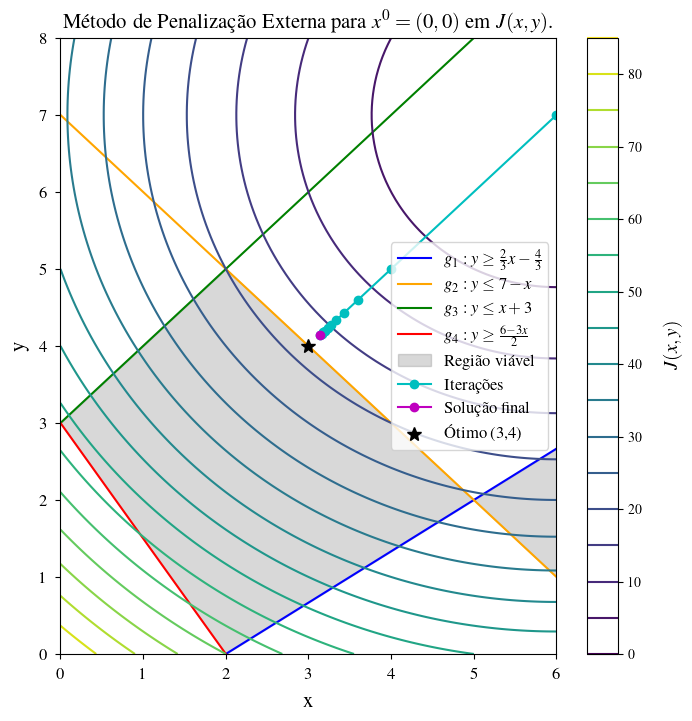

In [70]:
plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times"],
        "text.latex.preamble": r'\usepackage{amsfonts}',
        "text.usetex": True
    })
px = 1/plt.rcParams["figure.dpi"]

"""
Regiao viavel: definir poligono
Restricoes:
    - g1: (2/3)x - y <= 4/3 => y >= (2/3)x - 4/3
    - g2: x + y <= 7        => y <= 7 - x
    - g3: x - y >= -3       => y <= x + 3
    - g4: 3x + 2y >= 6      => y >= (6 - 3x)/2
"""

xs = np.linspace(0, 6, 100)
y_g1 = (2/3)*xs - 4/3
y_g2 = 7 - xs
y_g3 = xs + 3
y_g4 = (6 - 3*xs)/2

"""
Regiao viavel = Intersecao:
    y >= y_g1, y <= y_g2, y <= y_g3, y >= y_g4
Portanto, y entre max(y_g1, y_g4) e min(y_g2, y_g3).
"""

y_inf = np.maximum(y_g1, y_g4)
y_sup = np.minimum(y_g2, y_g3)

# Curvas de nivel de J
X, Y = np.meshgrid(np.linspace(0, 6, 100), np.linspace(0, 8, 100))
Z = (X - 6)**2 + (Y - 7)**2

p_0 = np.array([0.0, 0.0])
resultados = metodo_penalizacao_externa(p_0, c_k, phi_J, psi_J)

# Plot
fig, eixo = plt.subplots(1, figsize=(800*px, 800*px))
plt.plot(xs, y_g1, label=r'$g_1: y \geq \frac{2}{3}x - \frac{4}{3}$', color="blue")
plt.plot(xs, y_g2, label=r'$g_2: y \leq 7 - x$', color="orange")
plt.plot(xs, y_g3, label=r'$g_3: y \leq x + 3$', color="green")
plt.plot(xs, y_g4, label=r'$g_4: y \geq \frac{6 - 3x}{2}$', color="red")
plt.fill_between(xs, y_inf, y_sup, color="gray", alpha=0.3, label="Região viável")

plt.contour(X, Y, Z, levels=20, cmap="viridis")
cbar = plt.colorbar()
cbar.set_label(label=r'$J(x,y)$', fontsize=14, labelpad=15)

# Sequencia de pontos
plt.plot(resultados[:,0], resultados[:,1], "co-", label="Iterações")
plt.plot(resultados[-1,0], resultados[-1,1], "mo-", label="Solução final")
plt.plot(3, 4, "k*", markersize=10, label="Ótimo (3,4)")

# Configurações
plt.xlim(0, 6)
plt.ylim(0, 8)
plt.legend(loc="best", frameon=True, fontsize=12)
plt.xlabel("x", labelpad=7.5, fontsize=15)
plt.ylabel("y", labelpad=7.5, fontsize=15)
eixo.tick_params(pad=6, labelsize=12)
plt.title(r'Método de Penalização Externa para $x^{0}=(0,0)$ em $J(x, y)$.', pad=7.5, fontsize=15)

plt.show()
fig.savefig(f"figures/exer_2-c.pdf", bbox_inches="tight", pad_inches=0)